<a href="https://colab.research.google.com/github/jevylux/pytorchtraining/blob/main/pytorchworkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
# pytorch workflow  - end-to-end-workflow

what_we_are_covering = {1: "data ( prepare and load)",
                        2: "build model",
                        3: "fitting the model to data (training)",
                        4: "making predictions and evaluating a model (inference)",
                        5: "saving and loading a model",
                        6: "putting it all together"}

import torch
from torch import nn  #nn contains al od pytorch building blocks regarding nn's
import matplotlib.pyplot as plt

# check pytoprch version
print(torch.__version__)




2.1.0+cu118


In [146]:
## Data - preparing and loading
# data can be almost anything , excel spreadsheet, images, videos, audio, DNA, text

# create known parameters
weight = 0.7
bias = 0.3

# create data. with a linear regression

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # unsqueeze is used to add an extra dimension. X in capital -> tensor
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [147]:
len(X), len(y)

(50, 50)

In [148]:
# splitting data into training and tests sets ( one of the most important concepts in deep learning
# create train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

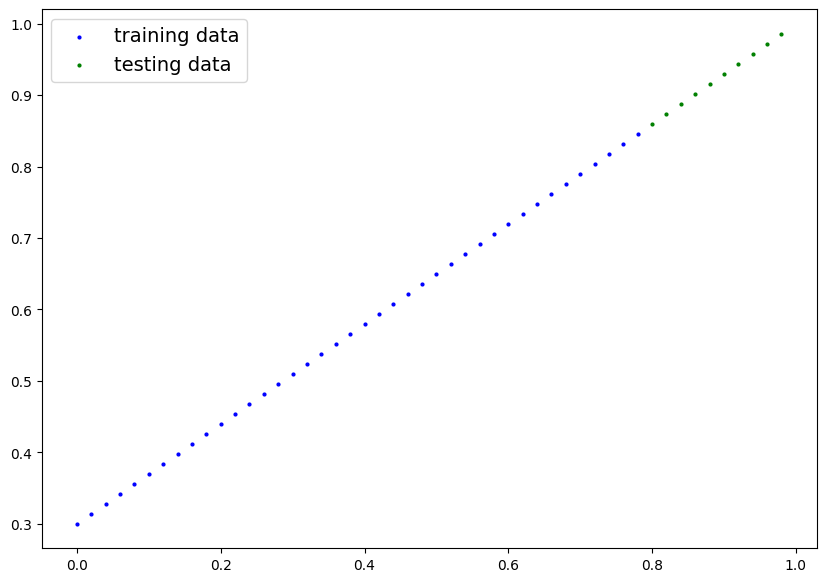

In [149]:
# how might be better visualize our data ? data explorer's mot : "visualize, visualize"
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="testing data")
  if predictions is not None:
    # plot predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  # Show the legend
  plt.legend(prop={"size": 14})

plot_predictions();

In [150]:
# build the model
from torch import nn
# create linear regression model class
# to lear classes see : https://realpython.com/python-classes/
class LinearRegressionModel(nn.Module):  # <- almost everything n pytorch inheretest from nn.Module : https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                        requires_grad=True,
                                        dtype=torch.float))
  #  forward method to define the computation in the model
  def forward(self,x:torch.Tensor) -> torch.Tensor: # <- "X" is the input data
    return self.weights * x + self.bias # this is the linear regression formula



In [151]:
# checking the content of our pytorch model
# create a random seed
torch.manual_seed(42)
# create instance of model
model_0 = LinearRegressionModel()
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [152]:
#list named parameters
model_0.state_dict()


OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [153]:
# making predictions using torch.inference_mode()
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

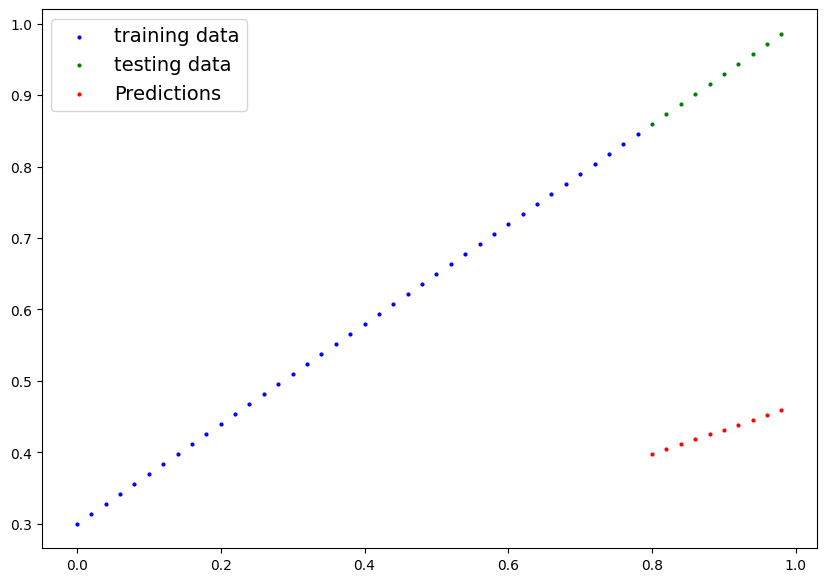

In [154]:
plot_predictions(predictions=y_preds)

In [155]:
# train model. - one way to measure how poor or wrong our predictions are is to use a loss function
# setup a loss function
# videos : gradient descent https://www.youtube.com/watch?v=Ilg3gGewQ5U and backpropagation https://www.youtube.com/watch?v=tIeHLnjs5U8

loss_fn = nn.L1Loss()

# setup an optimizer (stocastic gradient descent)

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)    # lr = learning rate =  possibly the most omportant hyperparamter

# now build the training (and a testing) loop
# an epoch is one loop true de dat

# in order to see how this works, change the value of epochs, let's say 10, 100 , 1000 and 10000 and rerun the complete notebook
# ( Runtime-> Run all) and see what happenss  wih the plots at cell 37

epochs = 1000 # this is a hyperparamter because we have set it ourselfs

# track different values
epoch_count = []
loss_values = []
test_loss_values = []


# Training
print(list(model_0.parameters()))
for epoch in range(epochs):

  # set the model to training mode
  model_0.train() # train mode in pytorch sets all parameters that require gradients to require gradients

  # forward pass
  y_pred = model_0(X_train)
  # calculate loss
  loss = loss_fn(y_pred, y_train)
  # optimizer zero grad
  optimizer.zero_grad()
  #perform backpropagation on the loss with respect to the paramters of the model
  loss.backward()
  # set the optimizer ( oerform gradient descent)
  optimizer.step()

  model_0.eval()  # turns off different settings in the model not needed for evaluation/testing (dropout/ batch norm)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
    # do the forward pass
    test_pred = model_0(X_test)
    # calculate the loss
    test_loss = loss_fn(test_pred, y_test)
  if epoch % 10 == 0:
    # update the tracking data ( only for reference, not used by the model)
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(f"Epoch : {epoch} | Loss: {loss} | Test loss : {test_loss }")
    print(model_0.state_dict())

print(list(model_0.parameters()))


[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
Epoch : 0 | Loss: 0.31288138031959534 | Test loss : 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch : 10 | Loss: 0.1976713240146637 | Test loss : 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch : 20 | Loss: 0.08908725529909134 | Test loss : 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch : 30 | Loss: 0.053148526698350906 | Test loss : 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch : 40 | Loss: 0.04543796554207802 | Test loss : 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch : 50 | Loss: 0.04167863354086876 | Test loss : 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch

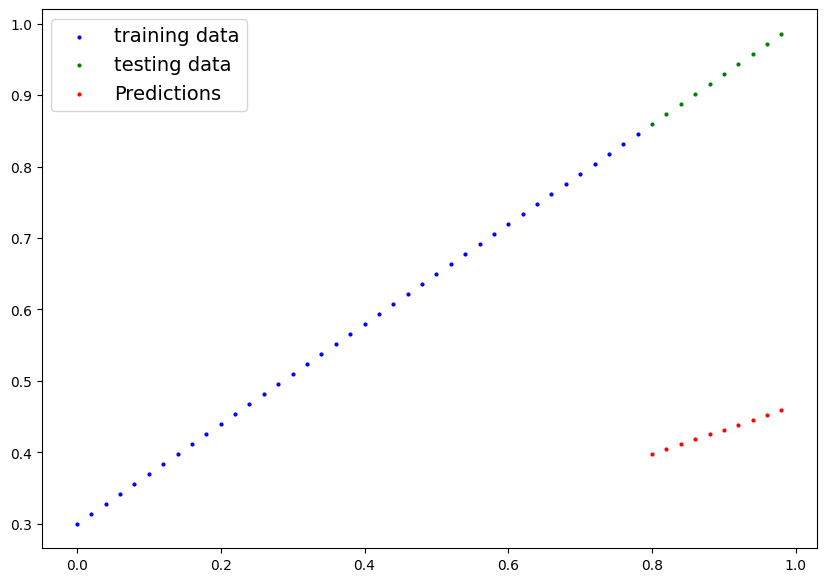

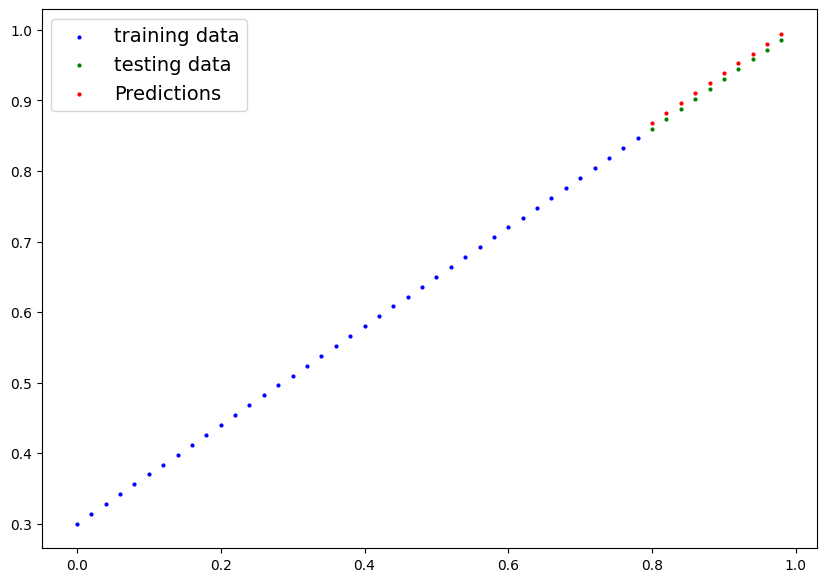

In [156]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
plot_predictions(predictions=y_preds)
plot_predictions(predictions=y_preds_new)

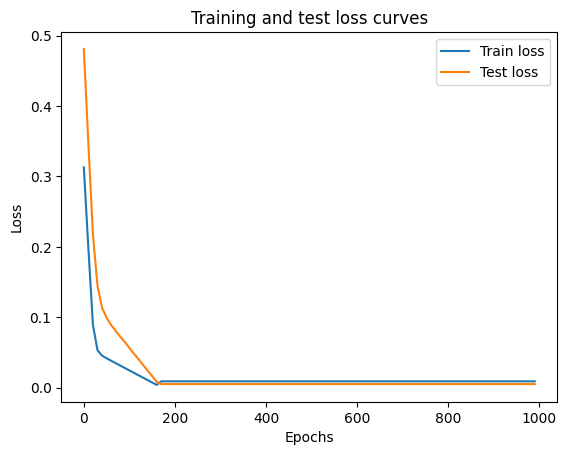

In [161]:
# plot the loss curves
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss") # we need to transform the tensor to a numpy array in order to be used in matplotlib
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [166]:
# now it is time to save the model to reuse it later https://pytorch.org/tutorials/beginner/saving_loading_models.html
# there are three main methosd to be are of in order to save and load models
# torch.save()  - allows you to save a Pytorch object in Python's pickle format ( https://docs.python.org/3/library/pickle.html)
# torch.load()  - allows to load a pytorch object from a pickle file
# torch.nn.Module.load_state_dict() - this allows to load a mopdel's saved stae dictionary

# saving a pytorch model
from pathlib import Path  #used to store the data locally in a defined place
# create a models directory. (will be in folder content)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEl_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEl_NAME
print(f" Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

! ls -l models.  # use ! to ecexcute local commands




 Saving model to models/01_pytorch_workflow_model_0.pth
total 4
-rw-r--r-- 1 root root 1680 Nov  1 11:11 01_pytorch_workflow_model_0.pth


In [175]:
# load the saved model
# since we only saved the  model's state_dict() rather than the entire model, we'll create a new instance of our model
# and load the saved state_dict() into that
loaded_model_0 = LinearRegressionModel()
# load the saved state_dict of model_0
print(f"Empyt model : {loaded_model_0.state_dict()}")
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
print(f"Loaded woith save data : {loaded_model_0.state_dict()}")

# make some predictions with our loaded model

loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_0_preds = loaded_model_0(X_test)
print(loaded_model_0_preds)
# compare loaded model preds with original preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds == loaded_model_0_preds

Empyt model : OrderedDict([('weights', tensor([-0.7658])), ('bias', tensor([-0.7506]))])
Loaded woith save data : OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])